In [1]:
from plot_utils import plot_cluster_size_distribution, analyze_bond_network, plot_rdfs, plot_3d_cluster_with_graph
from bondmodifier_utils import canonical_cluster_workflow, import_file, summarize_bonds
import numpy as np
import networkx as nx


In [2]:
# User inputs
infile = "/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.67/T1300K/dump.lammpstrj"
rdf_samples = 100  # adjust for speed/accuracy


In [17]:
pipe = import_file(infile, multiple_frames=True)
print(f"Loaded trajectory with {pipe.source.num_frames} frames")

# Disable Na-Cl bonds
result = canonical_cluster_workflow(
    pipeline=pipe,
    # disable_pair=("Na", "Cl"),
    metals=["Pu", "Na"],
    anion="Cl",
    rdf_samples=rdf_samples,
)

r = result["rdf"]
cutoffs = result["pair_cutoffs"]
print("Pairwise cutoffs:", cutoffs)



Loaded trajectory with 24594 frames
Pairwise cutoffs: {('Pu', 'Cl'): 3.9414224984318857, ('Cl', 'Pu'): 3.9414224984318857, ('Na', 'Cl'): 4.169931163443176, ('Cl', 'Na'): 4.169931163443176}


In [18]:
# cutoffs["Pu-Cl"]=2
# cutoffs["Na-Cl"]=2
# cutoffs["Na-Na"]=2
# cutoffs["Pu-Pu"]=2



In [19]:
result["rdf"].keys()

dict_keys(['Na-Na', 'Cl-Na', 'Na-Pu', 'Cl-Cl', 'Cl-Pu', 'Pu-Pu', 'r'])

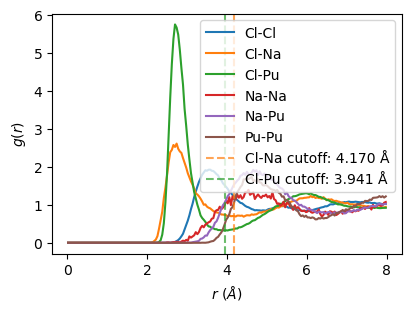

In [20]:
plot_rdfs(result["rdf"], cutoffs=cutoffs)

In [7]:
from bondmodifier_utils import build_shared_anion_graph

In [8]:
sizes, cluster_ids, G = build_shared_anion_graph(result["data"], result["names"], anion="Cl", metals=["Pu", "Na"])

Clusters: 1 | Largest: 576 | Avg: 576.00


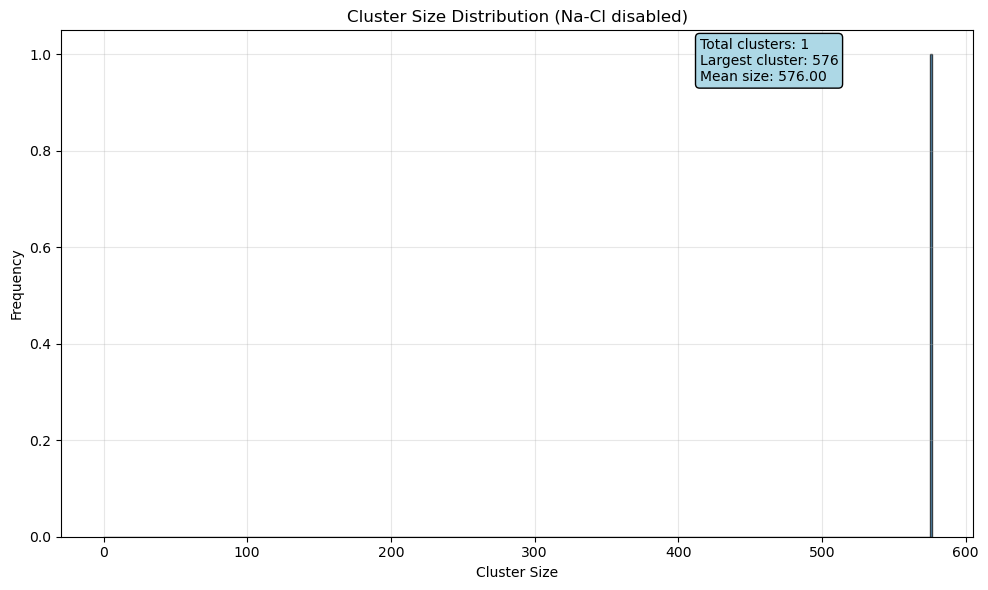

Bond counts: {'Cl-Pu': 2616, 'Cl-Na': 1249}


In [9]:
# Unpack results and analyze
names = result["names"]
sizes = result["sizes"]
cluster_ids = result["cluster_ids"]
data0 = result["data"]
G = result["graph"]

print(f"Clusters: {len(sizes)} | Largest: {np.max(sizes) if len(sizes)>0 else 0} | Avg: {np.mean(sizes) if len(sizes)>0 else 0:.2f}")

# Plot size distribution
plot_cluster_size_distribution(sizes, title="Cluster Size Distribution (Na-Cl disabled)")

# Bond summary
counts = summarize_bonds(data0, names)
print("Bond counts:", counts)



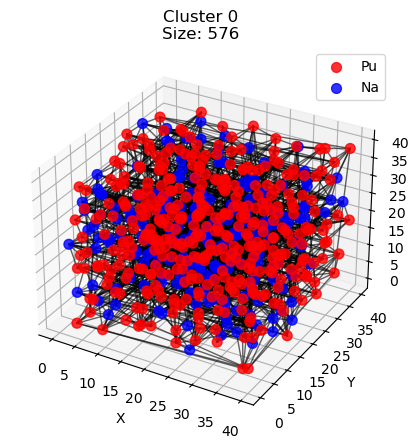

In [10]:
plot_3d_cluster_with_graph(data0, cluster_ids, names, G, 10)

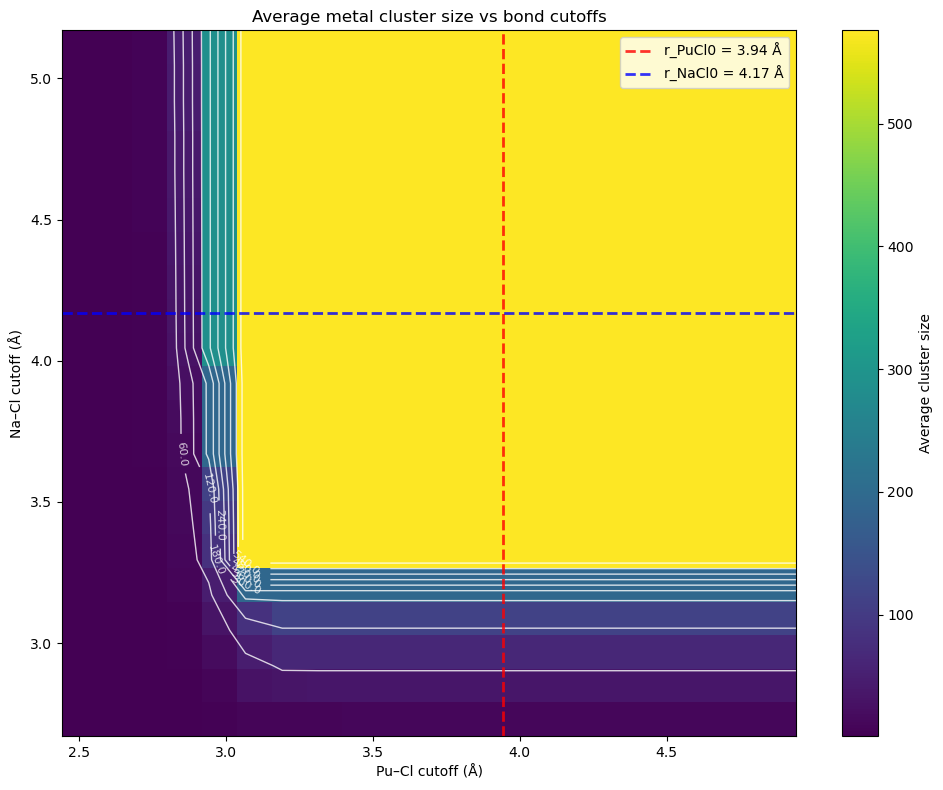

In [16]:
# Average cluster size heatmap vs Na–Cl and Pu–Cl cutoffs
import numpy as np
import matplotlib.pyplot as plt
from bondmodifier_utils import configure_bonds_modifier_from_cutoffs, build_shared_anion_graph

# Reuse existing pipeline and names/data helpers from previous cells
pipe = pipe  # from above

# Get a baseline frame to pull names later
base = pipe.compute(0)
names = result["names"] if "result" in globals() and "names" in result else None
if names is None:
    # Fallback: extract names from OVITO data
    from bondmodifier_utils import extract_names_array
    names = extract_names_array(base.particles)

# Define sweep ranges around the RDF-derived cutoffs
r_PuCl0 = float(cutoffs.get(("Pu","Cl"), cutoffs.get("Pu-Cl", 3.5)))
r_NaCl0 = float(cutoffs.get(("Na","Cl"), cutoffs.get("Na-Cl", 3.8)))

r_PuCl_vals = np.linspace(max(0.5, r_PuCl0 - 1.5), r_PuCl0 + 1.0, 21)  # Increased from 9 to 21 for finer grid
r_NaCl_vals = np.linspace(max(0.5, r_NaCl0 - 1.5), r_NaCl0 + 1.0, 21)  # Increased from 9 to 21 for finer grid

heat = np.zeros((len(r_NaCl_vals), len(r_PuCl_vals)), float)

for i, r_NaCl in enumerate(r_NaCl_vals):
    for j, r_PuCl in enumerate(r_PuCl_vals):
        # Configure bond cutoffs; mirror symmetric pairs
        pair_cutoffs = {
            ("Pu","Cl"): float(r_PuCl), ("Cl","Pu"): float(r_PuCl),
            ("Na","Cl"): float(r_NaCl), ("Cl","Na"): float(r_NaCl),
        }
        configure_bonds_modifier_from_cutoffs(pipe, pair_cutoffs)
        data = pipe.compute(0)
        # Build shared-anion connectivity among metals
        sizes, cluster_ids, G = build_shared_anion_graph(data, names, anion="Cl", metals=["Pu","Na"])  # noqa: F841
        heat[i, j] = float(np.mean(sizes)) if sizes.size > 0 else 0.0

plt.figure(figsize=(10, 8))  # Increased figure size
im = plt.imshow(heat, origin='lower', aspect='auto',
                extent=[r_PuCl_vals[0], r_PuCl_vals[-1], r_NaCl_vals[0], r_NaCl_vals[-1]],
                cmap='viridis')
plt.colorbar(im, label='Average cluster size')

# Add contour lines with cluster size labels
X, Y = np.meshgrid(r_PuCl_vals, r_NaCl_vals)
contours = plt.contour(X, Y, heat, levels=10, colors='white', alpha=0.8, linewidths=1)
plt.clabel(contours, fontsize=8, fmt='%.1f')

# Add reference lines for original cutoff values
plt.axvline(r_PuCl0, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'r_PuCl0 = {r_PuCl0:.2f} Å')
plt.axhline(r_NaCl0, color='blue', linestyle='--', linewidth=2, alpha=0.8, label=f'r_NaCl0 = {r_NaCl0:.2f} Å')
plt.legend()

plt.xlabel('Pu–Cl cutoff (Å)')
plt.ylabel('Na–Cl cutoff (Å)')
plt.title('Average metal cluster size vs bond cutoffs')
plt.tight_layout()
plt.show()
